Neuroon evaluation using metric functions
-----------------------------------------

Here we will compare neuroon staging against psg staging assumed to be ground truth. Confusion matrixes for binarized staging for each sleep stage will be used to plot results in ROC plot. Cohen cappa will be used to determine if the simmilarity between neuroon and psg was obtained by chance or randomly. 

Permutation test on accuracy score will be used to complement Cohen cappa.
Accuracy is defined as:

$$\frac{\sum{TruePositive} + \sum{TrueNegative}} {\sum{TotalPopulation}}$$

i.e. sum of confusion matrix diagonal divided by its total sum

Cohen cappa is the percent agreement between two raters corrected for possibility of agreement by chance.
Cohen cappa is defined as [1]:


$$\kappa = \frac{P(a) - P(e)}{1-P(e)}$$

* P(a) is the observed agreement
* P(e) is the chance agreement

$$ P(e) = \frac{\frac{cm^1 * rm^1}{n} + \frac{cm^2 * rm^2}{n}}{n} $$

where:
* cm1 represents column 1 marginal
* cm2 represents column 2 marginal
* rm1 represents row 1 marginal
* rm2 represents row 2 marginal

n represents the total number of observations

<img src="images/cohen_tresholds.png" ,width=400, height=400> 


[1] Mchugh, M. L. (2012). Interrater reliability : the kappa statistic. Biochemia Medica., 22(3), 276–282.

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import OrderedDict 
import parse_hipnogram as ph
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
import sklearn.metrics as metrics
from matplotlib.dates import  DateFormatter
import seaborn as sns
from datetime import timedelta
plt.rcParams['figure.figsize'] = (9.0, 5.0)
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.style.use('ggplot')

from statsmodels.stats.inter_rater import cohens_kappa, to_table
labels = ['rem','N1', 'N2', 'N3','wake']

stage_to_num = {'W':5, 'R':1, 'N1':2 , 'N2':3, 'N3':4 }
dummy_dict = {'stage_1': 'rem', 'stage_2' : 'N1', 'stage_3' : 'N2', 'stage_4': 'N3', 'stage_5':'wake'}


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
# load hipnograms, resample them and select their common time window

psg_hipnogram = ph.parse_psg_stages().resample('1s').fillna(method = 'ffill')
neuroon_hipnogram = ph.parse_neuroon_stages().resample('1s').fillna(method = 'ffill')

# Get the start and end of the time window covered by both hipnograms
start = neuroon_hipnogram.index.searchsorted(psg_hipnogram.index.get_values()[0])
end = psg_hipnogram.index.searchsorted(neuroon_hipnogram.index.get_values()[-1])

# Trim hipnograms to the common time window so the confusion matrix calculations are accurate
# +1 and -1 because events got cut in half, resulting in ends without starts
neuroon_hipnogram = neuroon_hipnogram.ix[start ::]
# +1 because upper bound is not included
psg_hipnogram = psg_hipnogram.ix[0:end +1]

In [67]:
# Create a list of staging predictions
true_stage = psg_hipnogram['stage_num'].as_matrix()
predicted_stage = neuroon_hipnogram['stage_num'].astype(int).as_matrix()

# Compute precision, recall and f1-score for the multilabel classification from neuroon
report = metrics.classification_report(true_stage,predicted_stage, target_names = labels )
# Compute accuracy, give it this name to use after permutation
original_accuracy = metrics.accuracy_score(true_stage,predicted_stage,)

print(report)
print('accuracy: %.2f'%original_accuracy)


             precision    recall  f1-score   support

        rem       0.57      0.58      0.58      4710
         N1       0.00      0.00      0.00      2760
         N2       0.46      0.79      0.58     10110
         N3       0.47      0.41      0.44      6690
       wake       0.57      0.03      0.05      3643

avg / total       0.45      0.48      0.42     27913

accuracy: 0.48


In [68]:
def binarize_stages(hipnogram):
    return pd.get_dummies(hipnogram, prefix = 'stage')

In [69]:

def confusion_matrix_separate():
    # make a confusion matrix for each stage binarized (stage = 1, all_other = 0)
    # TODO, neuroon stages saved as float, change to int upstream
    neuroon_binarized = binarize_stages(neuroon_hipnogram['stage_num'].astype(int))
    psg_binarized = binarize_stages(psg_hipnogram['stage_num'])
    
    fig, axes = plt.subplots(nrows = 2,ncols = 2, figsize = (8,8))
    for neuroon_stage, ax in zip(neuroon_binarized, axes.reshape(-1)):
        stage_true = neuroon_binarized[neuroon_stage].as_matrix()
        stage_predicted = psg_binarized[neuroon_stage].as_matrix()
        cm = confusion_matrix(stage_true, stage_predicted)
        print(dummy_dict[neuroon_stage])
        table = cohens_kappa(cm)
        # uncomment to see other results, confidence intervals 
        print('max kappa %.2f'%table.kappa_max)
        print(table)
        

        # Normalize the confusion matrix by row (i.e by the number of samplesin each class)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        sns.heatmap(cm_normalized, annot = True, xticklabels = ['yes','no'],  yticklabels = ['yes','no'],fmt = '.2f', ax = ax)
        
        ax.set_title(dummy_dict[neuroon_stage] + '\n Cohen cappa: %.2f'%table.kappa)
        ax.set_ylabel('psg')
        ax.set_xlabel('neuroon')
        fig.tight_layout()

rem
max kappa 0.99
                  Simple Kappa Coefficient
              --------------------------------
              Kappa                     0.4902
              ASE                       0.0069
              95% Lower Conf Limit      0.4766
              95% Upper Conf Limit      0.5038

                 Test of H0: Simple Kappa = 0

              ASE under H0              0.0060
              Z                         81.9062
              One-sided Pr >  Z         0.0000
              Two-sided Pr > |Z|        0.0000

N2
max kappa 0.52
                  Simple Kappa Coefficient
              --------------------------------
              Kappa                     0.2331
              ASE                       0.0050
              95% Lower Conf Limit      0.2233
              95% Upper Conf Limit      0.2429

                 Test of H0: Simple Kappa = 0

              ASE under H0              0.0053
              Z                         44.2625
              One-sided Pr

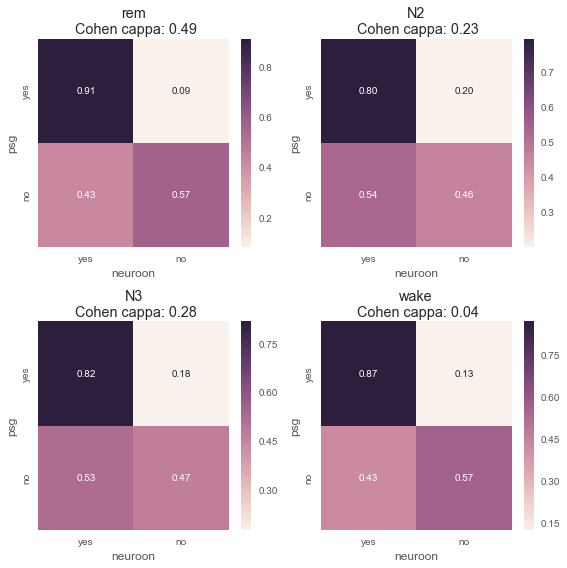

In [70]:
confusion_matrix_separate()

In [71]:
def permute_neuroon_staging():
    # load hipnograms, resample them and select their common time window
    neuroon_hipnogram = ph.parse_neuroon_stages(permute = True).resample('1s').fillna(method = 'ffill')
    psg_hipnogram = ph.parse_psg_stages().resample('1s').fillna(method = 'ffill')

    # Get the start and end of the time window covered by both hipnograms
    start = neuroon_hipnogram.index.searchsorted(psg_hipnogram.index.get_values()[0])
    end = psg_hipnogram.index.searchsorted(neuroon_hipnogram.index.get_values()[-1])

    # Trim hipnograms to the common time window so the confusion matrix calculations are accurate
    # +1 and -1 because events got cut in half, resulting in ends without starts
    neuroon_hipnogram = neuroon_hipnogram.ix[start ::]
    # +1 because upper bound is not included
    psg_hipnogram = psg_hipnogram.ix[0:end +1]
    
    true_stage = psg_hipnogram['stage_num'].as_matrix()
    predicted_stage = neuroon_hipnogram['stage_num'].astype(int).as_matrix()
    
    acc_score = metrics.accuracy_score(true_stage,predicted_stage,)
    return acc_score

In [72]:
num_perm = 100
permuted_accuracy = []
for i in range(num_perm):
    permuted_accuracy.append(permute_neuroon_staging())

permuted_accuracy = np.array(permuted_accuracy)

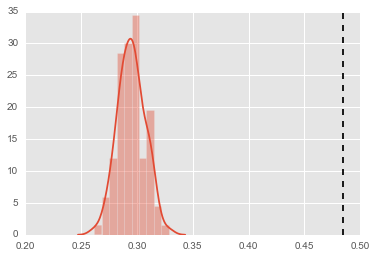

In [76]:
fig, axes = plt.subplots()
axes.axvline(original_accuracy, color = 'k', linestyle = '--')
sns.distplot(permuted_accuracy, ax = axes)